In [1]:
import scipy.io
import os
import sys
sys.path.insert(0,'..')
from rnn.model import RNN
from rnn.task import trial_generator
import numpy as np
from analysis.tf_utils import *
from analysis.analysis_utils import *
from scipy.stats import zscore
from itertools import permutations
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.animation import FuncAnimation
# from parula import Parula
from cycler import cycler
from analysis.summary import run_summary
from matplotlib import gridspec
from matplotlib.ticker import StrMethodFormatter
import pickle
%matplotlib inline

# Experiment settings

In [2]:
base_dir = ""
task_dir = "datasweep_main.pkl"

summary_settings = {
    "upsample" : 1, # Increase temporal resolution
    "ref_phase" : "sine", # Reference phase for 'spike-phase' histogram, either sine or LFP
    "onlyGaba" : False,  # Only use inhibitory neurons for calculating LFP
    "cutoff_p": 10e-3, # For Wilc p test
    "normalize_fr_extract":  True,  # Normalize extracted firing rates
    "n_trials": 224,  # Number trials used in analysis
    "randomize_onset": False, # Randomise stimulus onset
    "delay_ms": 2500, # Delay time in ms
    "disable_noise": False, # With or without noise
    "freqs_l": np.logspace(*np.log10([1, 25]), num=50), # Frequencies for spectrograms
    "balance_trials": True, # Draw trials with balanced proportion of each stimuli
    "substr_mean_LFP": False, # Substract mean LFP
    "delay_buffer1": 25, # Disregard short period after stimulus offset
    "delay_buffer2": 25, # Disregard short period before probe onset
    "nbins": 20, # Number of bins for 'spike' phase histograms
    "common_baseline" : True, # Common baseline
    "freqs": [1, 1.5, 1.75, 2.04, 2.37, 2.75, 3.21, 3.73, 4.35, 5] # Frequencies for vex plots
}
pltcolors, pltcolors_alt = steffiscolours()


# Run or load summary over many models

In [3]:
model_dir = os.path.join(base_dir, "..", "models/sweep_main")
data_dir = "../data/"+str(task_dir)
data_list, summary_settings = run_summary(summary_settings, model_dir, data_dir)


In [4]:
data_list.keys()

dict_keys(['model_names', 'loss_f', 'acc', 'val_acc', 'train_acc', 'pre_spectrum', 'post_spectrum', 'ranked_neurons', 'wilc_ps', 'd_primes', 'vex', 'shvex', 'vex_f', 'phase_order', 'kappas', 'low_vex', 'low_shvex', 'low_kappas', 'summary_settings'])

# Generate plots

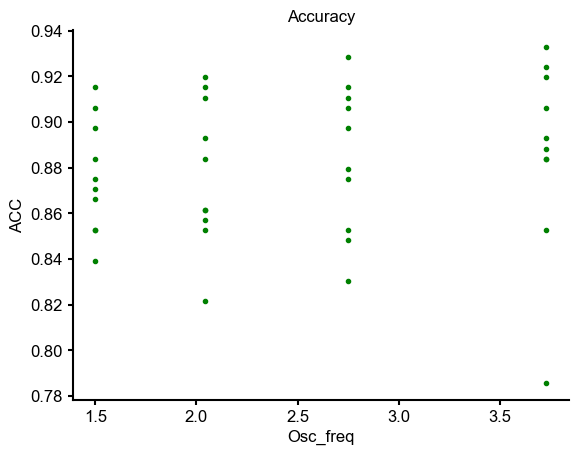

In [5]:
# Plot accuracies of all trained models

acc_threshold = 0.70
acc_indices = []
for i in range(len(data_list["acc"])):
    if data_list["acc"][i]>acc_threshold:
        plt.scatter(data_list["loss_f"][i], data_list["acc"][i], color = 'green')
        acc_indices.append(i)
    else:
        plt.scatter(data_list["loss_f"][i], data_list["acc"][i], color = 'red')

plt.xlabel("Osc_freq")
plt.ylabel("ACC")
plt.title("Accuracy");

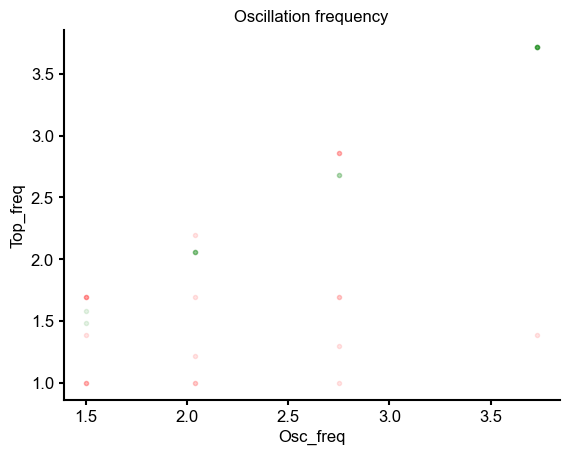

In [38]:
# Plot oscillation frequency for all trained models

fr_l = data_list["summary_settings"]["freqs_l"]
plt_indices = []
for i in acc_indices:
    osc_freq = fr_l[np.argmax(np.mean(data_list["post_spectrum"][i],axis=1))]
    
    if np.isclose(data_list["loss_f"][i], osc_freq, atol=.1):
        plt.scatter(data_list["loss_f"][i],osc_freq, color= 'green', alpha = 0.1)
        plt_indices.append(i)

    else:
        plt.scatter(data_list["loss_f"][i], osc_freq, color = 'red', alpha = 0.1)
plt.xlabel("Osc_freq")
plt.ylabel("Top_freq")
plt.title("Oscillation frequency");


In [39]:
data_list['model_names'][0]

'k56ppwz0SpecRad1.5DaleTrueTC20_100rand0sparse1osc2.75cost0.1'

In [40]:
accs_over_models = [[],[],[],[]]
freqs=[1.5,2.04,2.75,3.73]
for freq_i, freq in enumerate(freqs):
    for ind in plt_indices:
        fname = data_list['model_names'][ind]
        model_file = os.path.join(model_dir, fname)
        net = RNN()
        var = scipy.io.loadmat(model_file)
        if np.isclose(var['lossF'][0][0],freq):
            net.load_model(model_file)
            model_par, settings = reinstate_params(var)

            #trial generator
            trial_gen = trial_generator(
                int(var["n_items"][0][0]),
                net.n_channels,
                net.out_channels,
                val_perc=0,
            )

            delays = np.arange(150,600,5)
            accs = extrapolate_delays(128,delays,settings,trial_gen,net)
            accs_over_models[freq_i].append(accs)

Num GPUs Available:  0
Num GPUs Available:  0
Num GPUs Available:  0
Num GPUs Available:  0
Num GPUs Available:  0
Num GPUs Available:  0
Num GPUs Available:  0
balanced trials converged
delay 150
54
accuracy = 0.421875
delay 155
57
accuracy = 0.4453125
delay 160
52
accuracy = 0.40625
delay 165
57
accuracy = 0.4453125
delay 170
65
accuracy = 0.5078125
delay 175
97
accuracy = 0.7578125
delay 180
99
accuracy = 0.7734375
delay 185
88
accuracy = 0.6875
delay 190
80
accuracy = 0.625
delay 195
62
accuracy = 0.484375
delay 200
60
accuracy = 0.46875
delay 205
58
accuracy = 0.453125
delay 210
48
accuracy = 0.375
delay 215
52
accuracy = 0.40625
delay 220
56
accuracy = 0.4375
delay 225
51
accuracy = 0.3984375
delay 230
56
accuracy = 0.4375
delay 235
61
accuracy = 0.4765625
delay 240
78
accuracy = 0.609375
delay 245
96
accuracy = 0.75
delay 250
115
accuracy = 0.8984375
delay 255
92
accuracy = 0.71875
delay 260
86
accuracy = 0.671875
delay 265
62
accuracy = 0.484375
delay 270
56
accuracy = 0.4375
d

49
accuracy = 0.3828125
delay 415
53
accuracy = 0.4140625
delay 420
56
accuracy = 0.4375
delay 425
55
accuracy = 0.4296875
delay 430
79
accuracy = 0.6171875
delay 435
116
accuracy = 0.90625
delay 440
71
accuracy = 0.5546875
delay 445
65
accuracy = 0.5078125
delay 450
55
accuracy = 0.4296875
delay 455
55
accuracy = 0.4296875
delay 460
52
accuracy = 0.40625
delay 465
57
accuracy = 0.4453125
delay 470
57
accuracy = 0.4453125
delay 475
82
accuracy = 0.640625
delay 480
104
accuracy = 0.8125
delay 485
90
accuracy = 0.703125
delay 490
58
accuracy = 0.453125
delay 495
52
accuracy = 0.40625
delay 500
52
accuracy = 0.40625
delay 505
56
accuracy = 0.4375
delay 510
55
accuracy = 0.4296875
delay 515
56
accuracy = 0.4375
delay 520
69
accuracy = 0.5390625
delay 525
110
accuracy = 0.859375
delay 530
96
accuracy = 0.75
delay 535
70
accuracy = 0.546875
delay 540
50
accuracy = 0.390625
delay 545
55
accuracy = 0.4296875
delay 550
54
accuracy = 0.421875
delay 555
53
accuracy = 0.4140625
delay 560
58
accura

59
accuracy = 0.4609375
delay 240
59
accuracy = 0.4609375
delay 245
81
accuracy = 0.6328125
delay 250
114
accuracy = 0.890625
delay 255
93
accuracy = 0.7265625
delay 260
60
accuracy = 0.46875
delay 265
51
accuracy = 0.3984375
delay 270
57
accuracy = 0.4453125
delay 275
54
accuracy = 0.421875
delay 280
50
accuracy = 0.390625
delay 285
62
accuracy = 0.484375
delay 290
53
accuracy = 0.4140625
delay 295
102
accuracy = 0.796875
delay 300
85
accuracy = 0.6640625
delay 305
63
accuracy = 0.4921875
delay 310
55
accuracy = 0.4296875
delay 315
54
accuracy = 0.421875
delay 320
56
accuracy = 0.4375
delay 325
51
accuracy = 0.3984375
delay 330
56
accuracy = 0.4375
delay 335
67
accuracy = 0.5234375
delay 340
98
accuracy = 0.765625
delay 345
107
accuracy = 0.8359375
delay 350
67
accuracy = 0.5234375
delay 355
55
accuracy = 0.4296875
delay 360
58
accuracy = 0.453125
delay 365
51
accuracy = 0.3984375
delay 370
58
accuracy = 0.453125
delay 375
53
accuracy = 0.4140625
delay 380
63
accuracy = 0.4921875
dela

57
accuracy = 0.4453125
delay 555
96
accuracy = 0.75
delay 560
74
accuracy = 0.578125
delay 565
63
accuracy = 0.4921875
delay 570
56
accuracy = 0.4375
delay 575
62
accuracy = 0.484375
delay 580
62
accuracy = 0.484375
delay 585
60
accuracy = 0.46875
delay 590
67
accuracy = 0.5234375
delay 595
106
accuracy = 0.828125
Num GPUs Available:  0
Num GPUs Available:  0
Num GPUs Available:  0
Num GPUs Available:  0
Num GPUs Available:  0
Num GPUs Available:  0
Num GPUs Available:  0
Num GPUs Available:  0
balanced trials converged
delay 150
61
accuracy = 0.4765625
delay 155
66
accuracy = 0.515625
delay 160
65
accuracy = 0.5078125
delay 165
71
accuracy = 0.5546875
delay 170
102
accuracy = 0.796875
delay 175
91
accuracy = 0.7109375
delay 180
61
accuracy = 0.4765625
delay 185
67
accuracy = 0.5234375
delay 190
63
accuracy = 0.4921875
delay 195
62
accuracy = 0.484375
delay 200
67
accuracy = 0.5234375
delay 205
73
accuracy = 0.5703125
delay 210
112
accuracy = 0.875
delay 215
83
accuracy = 0.6484375
de

58
accuracy = 0.453125
delay 370
59
accuracy = 0.4609375
delay 375
56
accuracy = 0.4375
delay 380
50
accuracy = 0.390625
delay 385
55
accuracy = 0.4296875
delay 390
49
accuracy = 0.3828125
delay 395
54
accuracy = 0.421875
delay 400
55
accuracy = 0.4296875
delay 405
62
accuracy = 0.484375
delay 410
58
accuracy = 0.453125
delay 415
56
accuracy = 0.4375
delay 420
56
accuracy = 0.4375
delay 425
73
accuracy = 0.5703125
delay 430
83
accuracy = 0.6484375
delay 435
75
accuracy = 0.5859375
delay 440
64
accuracy = 0.5
delay 445
64
accuracy = 0.5
delay 450
90
accuracy = 0.703125
delay 455
101
accuracy = 0.7890625
delay 460
99
accuracy = 0.7734375
delay 465
76
accuracy = 0.59375
delay 470
59
accuracy = 0.4609375
delay 475
70
accuracy = 0.546875
delay 480
87
accuracy = 0.6796875
delay 485
85
accuracy = 0.6640625
delay 490
63
accuracy = 0.4921875
delay 495
49
accuracy = 0.3828125
delay 500
55
accuracy = 0.4296875
delay 505
66
accuracy = 0.515625
delay 510
66
accuracy = 0.515625
delay 515
66
accuracy

86
accuracy = 0.671875
delay 225
107
accuracy = 0.8359375
delay 230
93
accuracy = 0.7265625
delay 235
62
accuracy = 0.484375
delay 240
65
accuracy = 0.5078125
delay 245
88
accuracy = 0.6875
delay 250
116
accuracy = 0.90625
delay 255
98
accuracy = 0.765625
delay 260
50
accuracy = 0.390625
delay 265
57
accuracy = 0.4453125
delay 270
68
accuracy = 0.53125
delay 275
93
accuracy = 0.7265625
delay 280
78
accuracy = 0.609375
delay 285
62
accuracy = 0.484375
delay 290
59
accuracy = 0.4609375
delay 295
56
accuracy = 0.4375
delay 300
62
accuracy = 0.484375
delay 305
62
accuracy = 0.484375
delay 310
53
accuracy = 0.4140625
delay 315
57
accuracy = 0.4453125
delay 320
49
accuracy = 0.3828125
delay 325
59
accuracy = 0.4609375
delay 330
57
accuracy = 0.4453125
delay 335
53
accuracy = 0.4140625
delay 340
51
accuracy = 0.3984375
delay 345
59
accuracy = 0.4609375
delay 350
57
accuracy = 0.4453125
delay 355
68
accuracy = 0.53125
delay 360
58
accuracy = 0.453125
delay 365
59
accuracy = 0.4609375
delay 370

59
accuracy = 0.4609375
delay 535
66
accuracy = 0.515625
delay 540
56
accuracy = 0.4375
delay 545
54
accuracy = 0.421875
delay 550
63
accuracy = 0.4921875
delay 555
76
accuracy = 0.59375
delay 560
68
accuracy = 0.53125
delay 565
58
accuracy = 0.453125
delay 570
59
accuracy = 0.4609375
delay 575
58
accuracy = 0.453125
delay 580
58
accuracy = 0.453125
delay 585
58
accuracy = 0.453125
delay 590
54
accuracy = 0.421875
delay 595
52
accuracy = 0.40625
Num GPUs Available:  0
balanced trials converged
delay 150
56
accuracy = 0.4375
delay 155
57
accuracy = 0.4453125
delay 160
57
accuracy = 0.4453125
delay 165
62
accuracy = 0.484375
delay 170
56
accuracy = 0.4375
delay 175
52
accuracy = 0.40625
delay 180
54
accuracy = 0.421875
delay 185
54
accuracy = 0.421875
delay 190
53
accuracy = 0.4140625
delay 195
55
accuracy = 0.4296875
delay 200
59
accuracy = 0.4609375
delay 205
64
accuracy = 0.5
delay 210
61
accuracy = 0.4765625
delay 215
54
accuracy = 0.421875
delay 220
56
accuracy = 0.4375
delay 225
79

54
accuracy = 0.421875
delay 400
56
accuracy = 0.4375
delay 405
61
accuracy = 0.4765625
delay 410
63
accuracy = 0.4921875
delay 415
57
accuracy = 0.4453125
delay 420
60
accuracy = 0.46875
delay 425
61
accuracy = 0.4765625
delay 430
63
accuracy = 0.4921875
delay 435
66
accuracy = 0.515625
delay 440
61
accuracy = 0.4765625
delay 445
64
accuracy = 0.5
delay 450
65
accuracy = 0.5078125
delay 455
92
accuracy = 0.71875
delay 460
95
accuracy = 0.7421875
delay 465
76
accuracy = 0.59375
delay 470
70
accuracy = 0.546875
delay 475
75
accuracy = 0.5859375
delay 480
92
accuracy = 0.71875
delay 485
100
accuracy = 0.78125
delay 490
72
accuracy = 0.5625
delay 495
67
accuracy = 0.5234375
delay 500
65
accuracy = 0.5078125
delay 505
71
accuracy = 0.5546875
delay 510
65
accuracy = 0.5078125
delay 515
62
accuracy = 0.484375
delay 520
58
accuracy = 0.453125
delay 525
61
accuracy = 0.4765625
delay 530
62
accuracy = 0.484375
delay 535
61
accuracy = 0.4765625
delay 540
62
accuracy = 0.484375
delay 545
56
accur

2
5
3
9


Text(0, 0.5, 'accuracy')

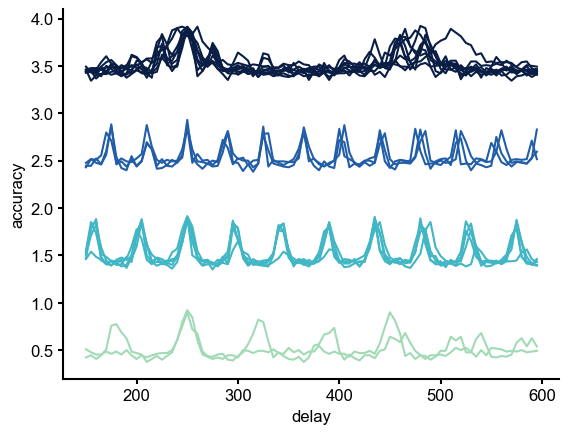

In [41]:
for i in range(4):
    plt.plot(delays,np.array(accs_over_models[i]).T+i,color=pltcolors_alt[i])
    print(len(accs_over_models[i]))
plt.xlabel("delay")
plt.ylabel("accuracy")

In [36]:
accs_over_models

[[array([0.421875 , 0.421875 , 0.3828125, 0.4140625, 0.5390625, 0.765625 ,
         0.8359375, 0.7265625, 0.546875 , 0.578125 , 0.453125 , 0.4375   ,
         0.4375   , 0.40625  , 0.4296875, 0.4296875, 0.3828125, 0.46875  ,
         0.59375  , 0.671875 , 0.8359375, 0.765625 , 0.5703125, 0.546875 ,
         0.40625  , 0.4375   , 0.375    , 0.4296875, 0.390625 , 0.4140625,
         0.4453125, 0.484375 , 0.65625  , 0.6484375, 0.828125 , 0.8046875,
         0.5390625, 0.40625  , 0.4375   , 0.40625  , 0.375    , 0.390625 ,
         0.4140625, 0.4140625, 0.4765625, 0.5703125, 0.6953125, 0.6015625,
         0.71875  , 0.7421875, 0.578125 , 0.4296875, 0.4296875, 0.4140625,
         0.421875 , 0.390625 , 0.3828125, 0.484375 , 0.5390625, 0.5234375,
         0.65625  , 0.609375 , 0.6328125, 0.671875 , 0.609375 , 0.40625  ,
         0.46875  , 0.3671875, 0.3828125, 0.4140625, 0.4609375, 0.5234375,
         0.5546875, 0.625    , 0.6328125, 0.5390625, 0.515625 , 0.578125 ,
         0.6328125, 0.546